### Data Creating and loading

In [5]:
import os 
current_path = os.getcwd()

In [6]:
current_path

'/home/ie643_therelutionaries/runcode/esc50_test'

In [3]:
import torch
import librosa
import numpy as np
from tqdm import tqdm
from torchvggish import vggish, vggish_input

In [15]:
model = vggish()

In [21]:
audio_path = "ESC-50/audio/"
paths = [audio_path+f for f in os.listdir(audio_path)]
print(paths)
len(paths)

['ESC-50/audio/4-194979-A-25.wav', 'ESC-50/audio/2-102581-B-29.wav', 'ESC-50/audio/3-117504-B-16.wav', 'ESC-50/audio/5-233019-A-31.wav', 'ESC-50/audio/4-181955-C-3.wav', 'ESC-50/audio/2-125875-A-13.wav', 'ESC-50/audio/1-100210-A-36.wav', 'ESC-50/audio/4-194808-A-29.wav', 'ESC-50/audio/4-165606-A-45.wav', 'ESC-50/audio/1-115521-A-19.wav', 'ESC-50/audio/5-261464-A-23.wav', 'ESC-50/audio/3-154926-B-40.wav', 'ESC-50/audio/2-110010-A-5.wav', 'ESC-50/audio/5-187201-A-4.wav', 'ESC-50/audio/1-103999-A-30.wav', 'ESC-50/audio/4-188703-A-8.wav', 'ESC-50/audio/1-37226-A-29.wav', 'ESC-50/audio/4-133895-A-7.wav', 'ESC-50/audio/5-177957-E-40.wav', 'ESC-50/audio/4-218199-A-35.wav', 'ESC-50/audio/2-106019-A-13.wav', 'ESC-50/audio/4-198360-C-49.wav', 'ESC-50/audio/2-102414-E-17.wav', 'ESC-50/audio/2-83688-A-34.wav', 'ESC-50/audio/2-37806-A-40.wav', 'ESC-50/audio/4-223125-A-14.wav', 'ESC-50/audio/2-93030-A-21.wav', 'ESC-50/audio/5-237795-A-34.wav', 'ESC-50/audio/5-200461-B-11.wav', 'ESC-50/audio/2-87412-

2000

In [22]:
embeddings_list = []
files_list = []

FIXED_T = 5   # desired number of patches

for idx, path in enumerate(tqdm(paths)):

    try:
        audio, sr = librosa.load(path, sr=16000, mono=True)
        examples = vggish_input.waveform_to_examples(audio, sr)  # (N,96,64)

        if examples.shape[0] == 0:
            print("Empty or too short, replacing with zeros:", path)
            emb_fixed = np.zeros((FIXED_T, 128), dtype=np.float32)

        else:
            examples = torch.tensor(examples).float()

            with torch.no_grad():
                emb_out = model(examples).cpu().numpy()  # (N,128)

            N = emb_out.shape[0]

            if N >= FIXED_T:
                # Downsample evenly or just take first 5
                indices = np.linspace(0, N-1, FIXED_T).astype(int)
                emb_fixed = emb_out[indices]
            else:
                # Pad with zeros
                pad = np.zeros((FIXED_T - N, 128), dtype=np.float32)
                emb_fixed = np.vstack([emb_out, pad])

        embeddings_list.append(emb_fixed)
        files_list.append(path)

    except Exception as e:
        print("Error processing", path, e)
        emb_fixed = np.zeros((FIXED_T, 128), dtype=np.float32)
        embeddings_list.append(emb_fixed)
        files_list.append(path)
        continue

# Convert to numpy array -> (num_files, 5, 128)
embeddings_array = np.stack(embeddings_list, axis=0)
print("Final embeddings shape:", embeddings_array.shape)


  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_657941/3083853943.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  examples = torch.tensor(examples).float()
100%|██████████| 2000/2000 [14:22<00:00,  2.32it/s]

Final embeddings shape: (2000, 5, 128)


In [4]:
import numpy as np 
np.save("esc50_audio_embeds.npy",embeddings_array)

NameError: name 'embeddings_array' is not defined

In [14]:
import pandas as pd 
y_data = pd.read_csv("./ESC-50/meta/esc50.csv")
y_data = y_data["category"].values
captions = y_data

In [15]:
pre = "an image of "

new_captions = [pre + caption for caption in captions]

for  i in new_captions:
    print(i)
    




an image of dog
an image of chirping_birds
an image of vacuum_cleaner
an image of vacuum_cleaner
an image of thunderstorm
an image of thunderstorm
an image of door_wood_knock
an image of can_opening
an image of crow
an image of door_wood_knock
an image of door_wood_knock
an image of clapping
an image of clapping
an image of clapping
an image of dog
an image of clapping
an image of thunderstorm
an image of fireworks
an image of fireworks
an image of fireworks
an image of fireworks
an image of clapping
an image of clapping
an image of clapping
an image of chainsaw
an image of airplane
an image of mouse_click
an image of pouring_water
an image of train
an image of sheep
an image of water_drops
an image of water_drops
an image of water_drops
an image of church_bells
an image of church_bells
an image of clock_alarm
an image of keyboard_typing
an image of wind
an image of clock_alarm
an image of footsteps
an image of footsteps
an image of footsteps
an image of footsteps
an image of footsteps

In [6]:
import torch
from diffusers import StableDiffusion3Pipeline

/home/ie643_therelutionaries/runcode/novelty/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
pipe = StableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers", # Using the diffusers-specific ID
    torch_dtype=torch.float16,
   
).to("cuda:0")


Loading pipeline components...: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]


In [17]:
pooled_embeddings = []

for idx, caption in enumerate(new_captions):
    with torch.no_grad():
        (_, _, pooled_embeds, _, embed1, embed2, embed3) = pipe.encode_prompt(
            prompt=caption,
            prompt_2=caption,
            prompt_3=caption,
            device=pipe.device,
            num_images_per_prompt=1,
            do_classifier_free_guidance=True
        )

    pooled_embeddings.append(pooled_embeds.cpu().numpy())

    print(f"\rEmbeddings created upto index :- {idx+1}", end="")


Embeddings created upto index :- 2000

In [20]:
pooled=np.array(pooled_embeddings)
np.save("esc50_text_pooled_embeds.npy",pooled)
print(pooled.shape)
pooled = pooled.squeeze(1)
print(pooled.shape)
np.save("esc50_text_pooled_embeds.npy",pooled)

(2000, 1, 2048)
(2000, 2048)


In [21]:
p = np.load("esc50_text_pooled_embeds.npy")
p.shape

(2000, 2048)

In [23]:
vggish = np.load("esc50_audio_embeds.npy")
vggish.shape

(2000, 5, 128)

In [25]:
esc50_vggish_mean = np.mean(vggish, axis=1)

print(esc50_vggish_mean.shape) 

np.save('esc50_vggish_mean',esc50_vggish_mean)
print("saved") # (2000

(2000, 128)
saved


In [18]:
import numpy as np
token_embeddings_1 = np.concatenate(token_embeddings_1, axis=0)
token_embeddings_2 = np.concatenate(token_embeddings_2, axis=0)
token_embeddings_3 = np.concatenate(token_embeddings_3, axis=0)

In [19]:
token_embeddings_2.shape

(2000, 20, 1280)

In [20]:
np.save("esc_clipl_embeds.npy", token_embeddings_1)
np.save("esc_clipg_embeds.npy", token_embeddings_2)
np.save("esc_t5_embeds.npy", token_embeddings_3)

In [21]:
token_embeddings_1 = np.load("esc_clipl_embeds.npy")
token_embeddings_2 = np.load("esc_clipg_embeds.npy")
token_embeddings_3 = np.load("esc_t5_embeds.npy")

In [22]:
token_embeddings_3.shape

(2000, 20, 4096)

### Experiment 1

In [4]:
import numpy as np 
import pandas as pd 
y1 = np.load("esc_clipl_embeds.npy")
y2 = np.load("esc_clipg_embeds.npy")
y3 = np.load("esc_t5_embeds.npy")
X = np.load("esc50_audio_embeds.npy")

In [5]:
print(f"X shape :- {X.shape}")
print(f"y1 Shape :- {y1.shape}")
print(f"y2 Shape :- {y2.shape}")
print(f"y3 Shape :- {y3.shape}")

X shape :- (2000, 5, 128)
y1 Shape :- (2000, 20, 768)
y2 Shape :- (2000, 20, 1280)
y3 Shape :- (2000, 20, 4096)


In [6]:
from sklearn.model_selection import train_test_split
X_train , X_test , y1_train , y1_test , y2_train , y2_test , y3_train , y3_test = train_test_split(X , y1 , y2 , y3 , test_size = 0.1 , shuffle=True , random_state = 43) 

In [7]:
del X
del y1 
del y2 
del y3

In [8]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
        

class MultiOutputTransformer(nn.Module):
    def __init__(self, input_dim=128, d_model=512, nhead=8, num_layers=4, ff_dim=1024):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=ff_dim,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Expand from 5 → 20 steps (learnable upsampling)
        self.upsample = nn.Linear(5, 20)

        # Output heads
        self.out1 = nn.Linear(d_model, 768)
        self.out2 = nn.Linear(d_model, 1280)
        self.out3 = nn.Linear(d_model, 4096)

    def forward(self, x):
        # x: (batch, 5, 128)
        x = self.input_proj(x)             # (B,10,512)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)    # (B,10,512)

        # expand time dimension
        x = x.transpose(1, 2)              # (B,512,10)
        x = self.upsample(x)               # (B,512,20)
        x = x.transpose(1, 2)              # (B,20,512)

        # output heads
        y1 = self.out1(x)   # (B,20,768)
        y2 = self.out2(x)   # (B,20,1280)
        y3 = self.out3(x)   # (B,20,4096)

        return y1, y2, y3


# Instantiate model
model = MultiOutputTransformer()
print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")


11.629176 M parameters


In [9]:
print(f"Shape of X train :- {X_train.shape}")
print(f"Shape of X test :- {X_test.shape}")
print(f"Shape of y1 train :- {y1_train.shape}")
print(f"Shape of y1 test :- {y1_test.shape}")
print(f"Shape of y2 train:- {y2_train.shape}")
print(f"Shape of y2 test :- {y2_test.shape}")
print(f"Shape of y3 train:- {y3_train.shape}")
print(f"Shape of y3 test :- {y3_test.shape}")

Shape of X train :- (1800, 5, 128)
Shape of X test :- (200, 5, 128)
Shape of y1 train :- (1800, 20, 768)
Shape of y1 test :- (200, 20, 768)
Shape of y2 train:- (1800, 20, 1280)
Shape of y2 test :- (200, 20, 1280)
Shape of y3 train:- (1800, 20, 4096)
Shape of y3 test :- (200, 20, 4096)


In [10]:
X_train = torch.tensor(X_train, dtype=torch.float32).cuda()
y1_train = torch.tensor(y1_train, dtype=torch.float32).cuda()
y2_train = torch.tensor(y2_train, dtype=torch.float32).cuda()
y3_train = torch.tensor(y3_train, dtype=torch.float32).cuda()
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_train, y1_train, y2_train, y3_train)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
from torch.utils.data import TensorDataset, DataLoader

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y1_test_t = torch.tensor(y1_test, dtype=torch.float32)
y2_test_t = torch.tensor(y2_test, dtype=torch.float32)
y3_test_t = torch.tensor(y3_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_t, y1_test_t, y2_test_t, y3_test_t)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 1/200 | Train Combined: 92.6944 | Val Combined: 92.0551 | Train MSE: 91.7671 | Val MSE: 91.2149 | Train Cos: 0.0726 | Val Cos: 0.1598
Model saved (new best).
Epoch 2/200 | Train Combined: 91.7904 | Val Combined: 91.3721 | Train MSE: 90.9398 | Val MSE: 90.5709 | Train Cos: 0.1493 | Val Cos: 0.1988
Model saved (new best).
Epoch 3/200 | Train Combined: 91.0703 | Val Combined: 90.5988 | Train MSE: 90.2465 | Val MSE: 89.8209 | Train Cos: 0.1762 | Val Cos: 0.2221
Model saved (new best).
Epoch 4/200 | Train Combined: 90.2410 | Val Combined: 89.6986 | Train MSE: 89.4387 | Val MSE: 88.9446 | Train Cos: 0.1977 | Val Cos: 0.2460
Model saved (new best).
Epoch 5/200 | Train Combined: 89.2802 | Val Combined: 88.6607 | Train MSE: 88.5000 | Val MSE: 87.9325 | Train Cos: 0.2198 | Val Cos: 0.2718
Model saved (new best).
Epoch 6/200 | Train Combined: 88.1785 | Val Combined: 87.4784 | Train MSE: 87.4230 | Val MSE: 86.7769 | Train Cos: 0.2445 | Val Cos: 0.2985
Model saved (new best).
Epoch 7/200 | Tr

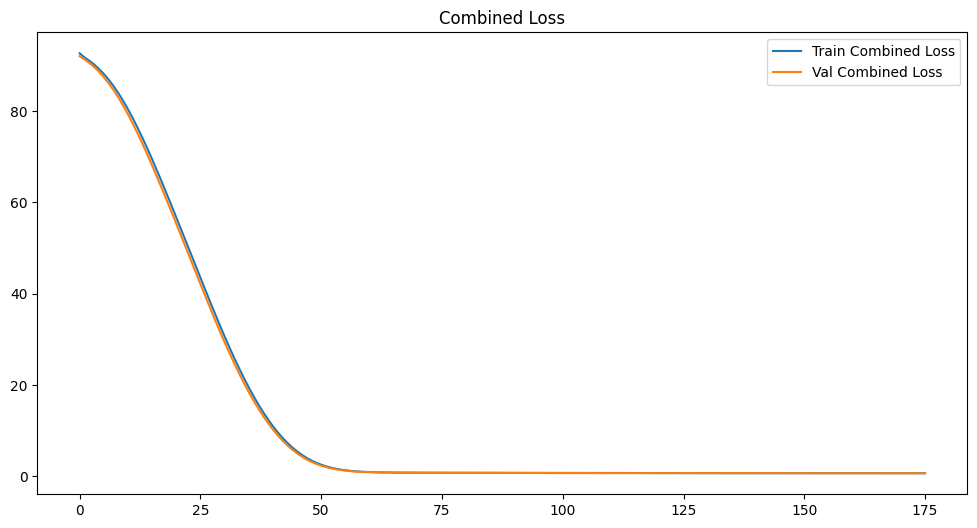

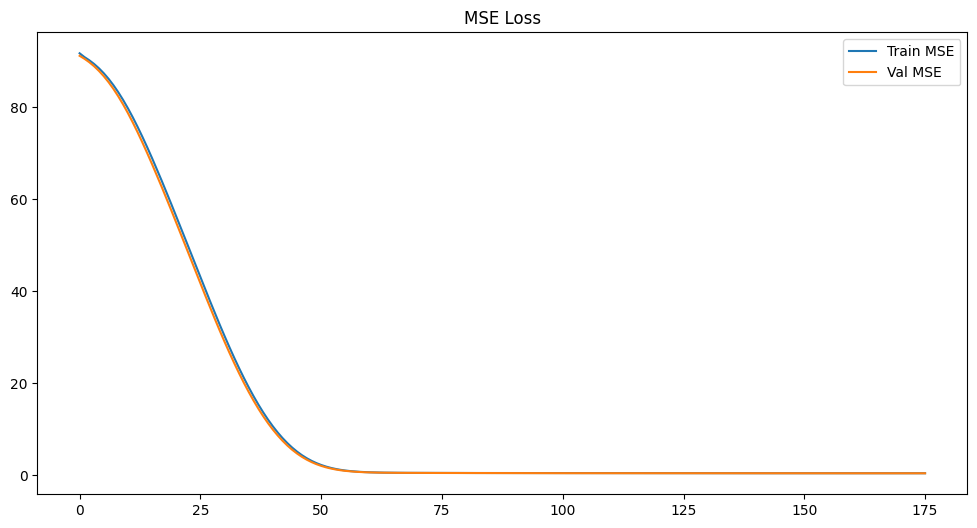

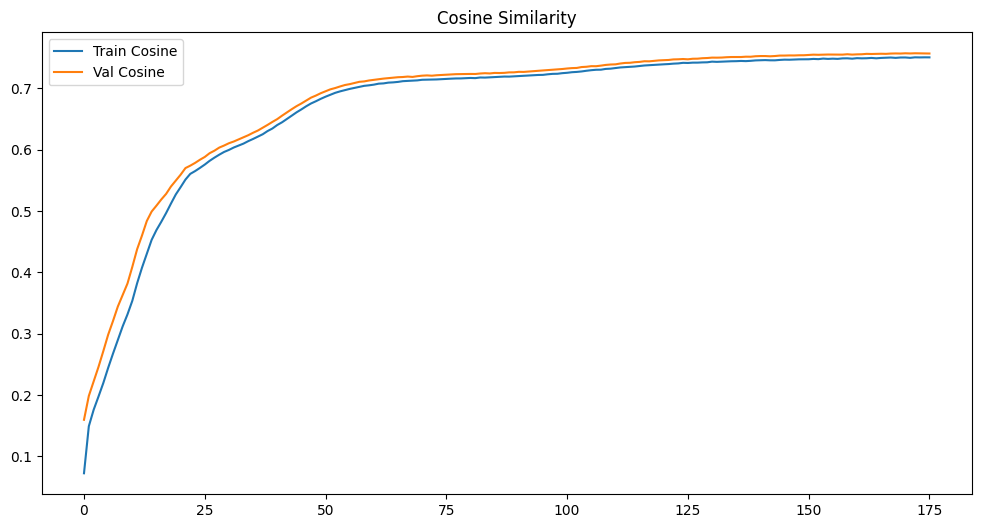

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define loss functions
mse_loss = nn.MSELoss()
cosine_fn = nn.CosineSimilarity(dim=-1)  # cosine per timestep

model = MultiOutputTransformer().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Metrics storage
train_combined_losses = []
train_mse_losses = []
train_cosine_avgs = []

val_combined_losses = []
val_mse_losses = []
val_cosine_avgs = []

best_val_loss = np.inf
patience = 5
patience_counter = 0

EPOCHS = 200

# ---------------- EVALUATION FUNCTION ---------------- #
def evaluate(model, loader):
    model.eval()
    total_combined = 0.0
    total_mse = 0.0
    total_cos = 0.0

    with torch.no_grad():
        for Xb, y1b, y2b, y3b in loader:
            Xb, y1b, y2b, y3b = Xb.cuda(), y1b.cuda(), y2b.cuda(), y3b.cuda()

            out1, out2, out3 = model(Xb)

            mse = (mse_loss(out1, y1b) +
                   mse_loss(out2, y2b) +
                   mse_loss(out3, y3b))

            cos1 = cosine_fn(out1, y1b).mean()
            cos2 = cosine_fn(out2, y2b).mean()
            cos3 = cosine_fn(out3, y3b).mean()

            avg_cos = (cos1 + cos2 + cos3) / 3.0
            combined_loss = mse + (1 - avg_cos)

            total_combined += combined_loss.item()
            total_mse += mse.item()
            total_cos += avg_cos.item()

    total_combined /= len(loader)
    total_mse /= len(loader)
    total_cos /= len(loader)

    return total_combined, total_mse, total_cos

# ---------------- TRAINING LOOP ---------------- #
for epoch in range(EPOCHS):
    model.train()

    epoch_combined = 0.0
    epoch_mse_val = 0.0
    epoch_cos_val = 0.0

    for Xb, y1b, y2b, y3b in loader:
        optimizer.zero_grad()

        Xb, y1b, y2b, y3b = Xb.cuda(), y1b.cuda(), y2b.cuda(), y3b.cuda()

        out1, out2, out3 = model(Xb)

        mse = (mse_loss(out1, y1b) +
               mse_loss(out2, y2b) +
               mse_loss(out3, y3b))

        cos1 = cosine_fn(out1, y1b).mean()
        cos2 = cosine_fn(out2, y2b).mean()
        cos3 = cosine_fn(out3, y3b).mean()

        avg_cos = (cos1 + cos2 + cos3) / 3.0

        combined_loss = mse + (1 - avg_cos)

        combined_loss.backward()
        optimizer.step()

        epoch_combined += combined_loss.item()
        epoch_mse_val += mse.item()
        epoch_cos_val += avg_cos.item()

    # Training epoch averages
    epoch_combined /= len(loader)
    epoch_mse_val /= len(loader)
    epoch_cos_val /= len(loader)

    train_combined_losses.append(epoch_combined)
    train_mse_losses.append(epoch_mse_val)
    train_cosine_avgs.append(epoch_cos_val)

    # ----- VALIDATION EVAL -----
    val_combined, val_mse, val_cos = evaluate(model, test_loader)

    val_combined_losses.append(val_combined)
    val_mse_losses.append(val_mse)
    val_cosine_avgs.append(val_cos)

    print(f"Epoch {epoch+1}/{EPOCHS} "
          f"| Train Combined: {epoch_combined:.4f} | Val Combined: {val_combined:.4f} "
          f"| Train MSE: {epoch_mse_val:.4f} | Val MSE: {val_mse:.4f} "
          f"| Train Cos: {epoch_cos_val:.4f} | Val Cos: {val_cos:.4f}")

    # ---- EARLY STOPPING ---- #
    if val_combined < best_val_loss:
        best_val_loss = val_combined
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_valid.pt")
        print("Model saved (new best).")
    else:
        patience_counter += 1
        print(f"No improvement. Patience {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# =================== PLOTS =================== #
plt.figure(figsize=(12,6))
plt.plot(train_combined_losses, label="Train Combined Loss")
plt.plot(val_combined_losses, label="Val Combined Loss")
plt.legend()
plt.title("Combined Loss")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(train_mse_losses, label="Train MSE")
plt.plot(val_mse_losses, label="Val MSE")
plt.legend()
plt.title("MSE Loss")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(train_cosine_avgs, label="Train Cosine")
plt.plot(val_cosine_avgs, label="Val Cosine")
plt.legend()
plt.title("Cosine Similarity")
plt.show()


### Experiment 2

Epoch 1/200 | Stage: MSE + COS | Train Combined: 100.1855 | Val Combined: 99.2201 | Train MSE: 93.2692 | Val MSE: 93.1575 | Train Cos: 0.1355 | Val Cos: 0.2422
Model saved (new best).
Epoch 2/200 | Stage: MSE + COS | Train Combined: 99.1817 | Val Combined: 98.6913 | Train MSE: 93.0948 | Val MSE: 93.0158 | Train Cos: 0.2391 | Val Cos: 0.2906
Model saved (new best).
Epoch 3/200 | Stage: MSE + COS | Train Combined: 98.7125 | Val Combined: 98.1937 | Train MSE: 92.9604 | Val MSE: 92.8935 | Train Cos: 0.2810 | Val Cos: 0.3375
Model saved (new best).
Epoch 4/200 | Stage: MSE + COS | Train Combined: 98.3054 | Val Combined: 97.8366 | Train MSE: 92.8355 | Val MSE: 92.7566 | Train Cos: 0.3163 | Val Cos: 0.3650
Model saved (new best).
Epoch 5/200 | Stage: MSE + COS | Train Combined: 97.9410 | Val Combined: 97.4700 | Train MSE: 92.6805 | Val MSE: 92.5805 | Train Cos: 0.3424 | Val Cos: 0.3888
Model saved (new best).
Epoch 6/200 | Stage: MSE + COS | Train Combined: 97.5649 | Val Combined: 97.0943 | T

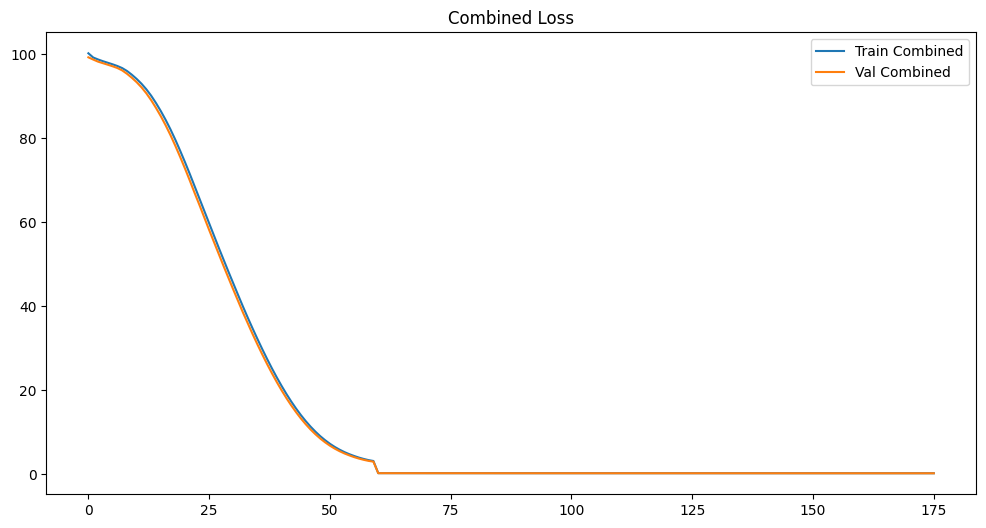

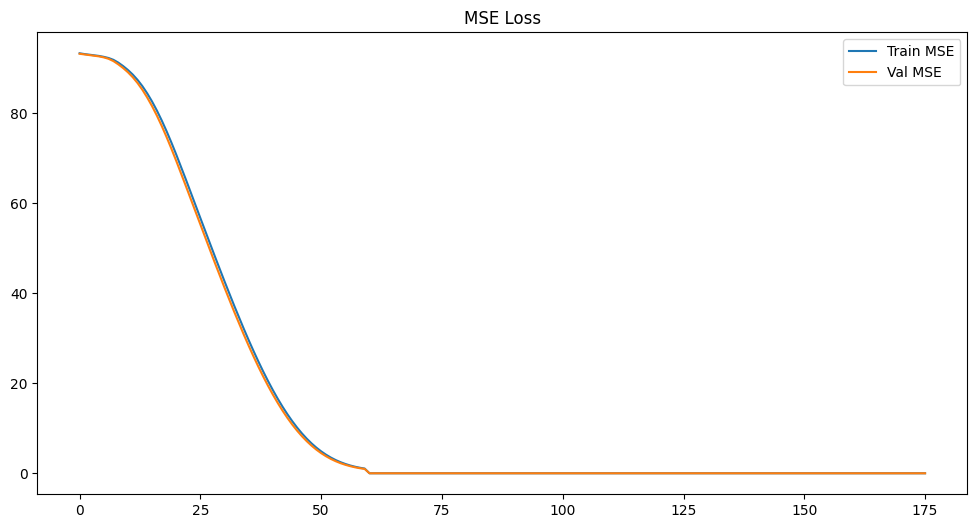

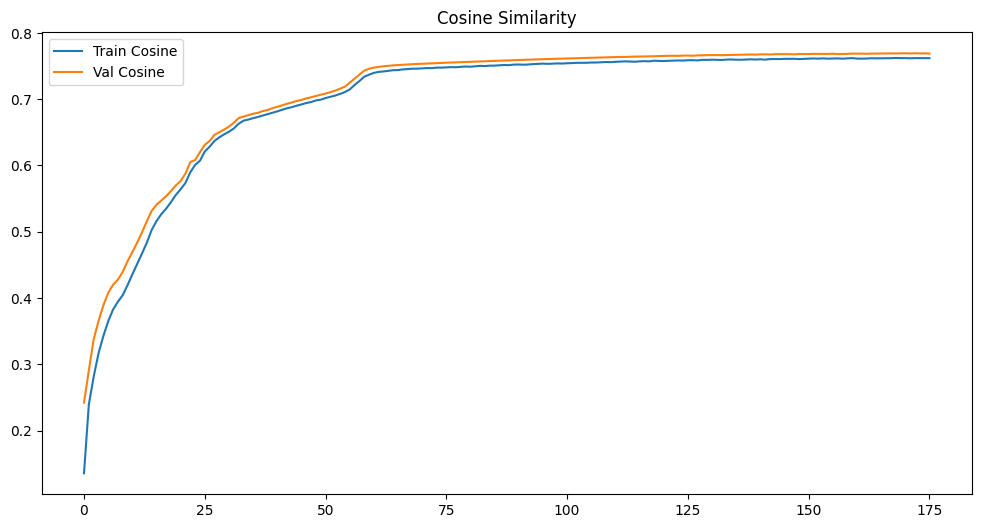

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define loss functions
mse_loss = nn.MSELoss()
cosine_fn = nn.CosineSimilarity(dim=-1)

model = MultiOutputTransformer().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Stage settings
STAGE1_EPOCHS = 60        # MSE + Cosine
STAGE2_EPOCHS = 140       # Cosine only
TOTAL_EPOCHS = STAGE1_EPOCHS + STAGE2_EPOCHS

alpha = 8                 # cosine loss weight in stage 1

# Metrics storage
train_combined_losses, train_mse_losses, train_cosine_avgs = [], [], []
val_combined_losses, val_mse_losses, val_cosine_avgs = [], [], []

best_val_loss = np.inf
patience = 5
patience_counter = 0

# ---------------- EVALUATION FUNCTION ---------------- #
def evaluate(model, loader, stage2=False):
    model.eval()
    total_combined, total_mse, total_cos = 0.0, 0.0, 0.0

    with torch.no_grad():
        for Xb, y1b, y2b, y3b in loader:
            Xb, y1b, y2b, y3b = Xb.cuda(), y1b.cuda(), y2b.cuda(), y3b.cuda()
            out1, out2, out3 = model(Xb)

            # cosine normalized values
            out1n = nn.functional.normalize(out1, dim=-1)
            out2n = nn.functional.normalize(out2, dim=-1)
            out3n = nn.functional.normalize(out3, dim=-1)
            y1n = nn.functional.normalize(y1b, dim=-1)
            y2n = nn.functional.normalize(y2b, dim=-1)
            y3n = nn.functional.normalize(y3b, dim=-1)

            cos1 = cosine_fn(out1n, y1n).mean()
            cos2 = cosine_fn(out2n, y2n).mean()
            cos3 = cosine_fn(out3n, y3n).mean()
            avg_cos = (cos1 + cos2 + cos3) / 3.0

            if stage2:
                combined_loss = (1 - avg_cos)
                mse = torch.tensor(0.0, device=Xb.device)
            else:
                mse = (mse_loss(out1, y1b) +
                       mse_loss(out2, y2b) +
                       mse_loss(out3, y3b))
                combined_loss = mse + alpha * (1 - avg_cos)

            total_combined += combined_loss.item()
            total_mse += mse.item()
            total_cos += avg_cos.item()

    return total_combined / len(loader), total_mse / len(loader), total_cos / len(loader)

# ---------------- TRAINING LOOP ---------------- #
for epoch in range(TOTAL_EPOCHS):
    stage2 = epoch >= STAGE1_EPOCHS  # switch point

    model.train()
    epoch_combined, epoch_mse_val, epoch_cos_val = 0.0, 0.0, 0.0

    for Xb, y1b, y2b, y3b in loader:
        optimizer.zero_grad()
        Xb, y1b, y2b, y3b = Xb.cuda(), y1b.cuda(), y2b.cuda(), y3b.cuda()
        out1, out2, out3 = model(Xb)

        # cosine values
        out1n = nn.functional.normalize(out1, dim=-1)
        out2n = nn.functional.normalize(out2, dim=-1)
        out3n = nn.functional.normalize(out3, dim=-1)
        y1n = nn.functional.normalize(y1b, dim=-1)
        y2n = nn.functional.normalize(y2b, dim=-1)
        y3n = nn.functional.normalize(y3b, dim=-1)

        cos1 = cosine_fn(out1n, y1n).mean()
        cos2 = cosine_fn(out2n, y2n).mean()
        cos3 = cosine_fn(out3n, y3n).mean()
        avg_cos = (cos1 + cos2 + cos3) / 3.0

        if stage2:
            mse = torch.tensor(0.0, device=Xb.device)
            combined_loss = (1 - avg_cos)
        else:
            mse = (mse_loss(out1, y1b) +
                   mse_loss(out2, y2b) +
                   mse_loss(out3, y3b))
            combined_loss = mse + alpha * (1 - avg_cos)

        combined_loss.backward()
        optimizer.step()

        epoch_combined += combined_loss.item()
        epoch_mse_val += mse.item()
        epoch_cos_val += avg_cos.item()

    # epoch averages
    epoch_combined /= len(loader)
    epoch_mse_val /= len(loader)
    epoch_cos_val /= len(loader)

    train_combined_losses.append(epoch_combined)
    train_mse_losses.append(epoch_mse_val)
    train_cosine_avgs.append(epoch_cos_val)

    # validation
    val_combined, val_mse, val_cos = evaluate(model, test_loader, stage2)
    val_combined_losses.append(val_combined)
    val_mse_losses.append(val_mse)
    val_cosine_avgs.append(val_cos)

    print(f"Epoch {epoch+1}/{TOTAL_EPOCHS} | Stage: {'COSINE ONLY' if stage2 else 'MSE + COS'} "
          f"| Train Combined: {epoch_combined:.4f} | Val Combined: {val_combined:.4f} "
          f"| Train MSE: {epoch_mse_val:.4f} | Val MSE: {val_mse:.4f} "
          f"| Train Cos: {epoch_cos_val:.4f} | Val Cos: {val_cos:.4f}")

    # ---- EARLY STOPPING ---- #
    if val_combined < best_val_loss:
        best_val_loss = val_combined
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_two_stage.pt")
        print("Model saved (new best).")
    else:
        patience_counter += 1
        print(f"No improvement. Patience {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# =================== PLOTS =================== #
plt.figure(figsize=(12,6))
plt.plot(train_combined_losses, label="Train Combined")
plt.plot(val_combined_losses, label="Val Combined")
plt.legend(); plt.title("Combined Loss"); plt.show()

plt.figure(figsize=(12,6))
plt.plot(train_mse_losses, label="Train MSE")
plt.plot(val_mse_losses, label="Val MSE")
plt.legend(); plt.title("MSE Loss"); plt.show()

plt.figure(figsize=(12,6))
plt.plot(train_cosine_avgs, label="Train Cosine")
plt.plot(val_cosine_avgs, label="Val Cosine")
plt.legend(); plt.title("Cosine Similarity"); plt.show()


In [2]:
import os
import torch

path = "/home/ie643_therelutionaries/runcode/esc50_test/ESC-50/audio"

count = 0
for entry in os.scandir(path):
    if entry.is_file():
        count += 1

print("Number of files:", count)


Number of files: 2000


In [7]:
import numpy as np
X = np.load("clap_embeddings_esc50.npy")
print(X.shape)
Y = np.load("esc50_text_pooled_embeds.npy")
print(Y.shape)



(2000, 512)
(2000, 2048)


### Vggish to POoled Mapping (ESC50)

In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# -------------------------
# Load numpy arrays
# -------------------------
# X: (66676, 128)
# Y: (66676, 2048)

# X = np.load(...)
# Y = np.load(...)

# -------------------------
# Train-test split
# -------------------------
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# -------------------------
# Dataset class
# -------------------------
class EmbDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = EmbDataset(X_train, Y_train)
test_dataset  = EmbDataset(X_test,  Y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)

# -------------------------
# Normal MLP Model (NO RESIDUALS)
# -------------------------
class TransformationNetwork(nn.Module):
    def __init__(self , input_dim =128, output_dim = 2048):
        super(TransformationNetwork , self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim , 512),
            nn.GELU(),
            nn.LayerNorm(512),  # Add this
            nn.Dropout(0.3),
            nn.Linear(512 , 1024),
            nn.GELU(),
            nn.LayerNorm(1024),
            nn.Dropout(0.3),
            nn.Linear(1024 , 1024),
            nn.GELU(),
            nn.LayerNorm(1024),
            nn.Dropout(0.4),
            nn.Linear(1024 , output_dim)
        )

    def forward(self , x):
        return self.layers(x)


# -------------------------
# Training setup
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformationNetwork().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=10
)

def embedding_loss(pred, target):
    cos = 1 - torch.nn.functional.cosine_similarity(pred, target).mean()
    mse = torch.nn.functional.mse_loss(pred, target)
    return 0.7*cos + 0.3*mse

# -------------------------
# Training loop with early stopping
# -------------------------
EPOCHS = 100
patience = 10
best_loss = float("inf")
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    for Xb, Yb in train_loader:
        Xb, Yb = Xb.to(device), Yb.to(device)

        pred = model(Xb)
        loss = embedding_loss(pred, Yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    # -------------------------
    # Validation
    # -------------------------
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, Yb in test_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            pred = model(Xb)
            val_loss += embedding_loss(pred, Yb).item()

    val_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train {total_loss/len(train_loader):.4f} | Val {val_loss:.4f}")

    # -------------------------
    # Early Stopping + Checkpoint
    # -------------------------
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0

        torch.save(model.state_dict(), "best_mlp_clap.pth")
        print("💾 Saved best model")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("⛔ Early stopping triggered")
        break

print(f"\n🔥 BEST Validation Loss: {best_loss:.6f}")


(1600, 128) (1600, 2048)
(400, 128) (400, 2048)
Epoch 1/100 | Train 0.8652 | Val 0.4785
💾 Saved best model
Epoch 2/100 | Train 0.5785 | Val 0.4197
💾 Saved best model
Epoch 3/100 | Train 0.5350 | Val 0.3963
💾 Saved best model
Epoch 4/100 | Train 0.5202 | Val 0.3895
💾 Saved best model
Epoch 5/100 | Train 0.5140 | Val 0.3878
💾 Saved best model
Epoch 6/100 | Train 0.5102 | Val 0.3875
💾 Saved best model
Epoch 7/100 | Train 0.5095 | Val 0.3872
💾 Saved best model
Epoch 8/100 | Train 0.5078 | Val 0.3871
💾 Saved best model
Epoch 9/100 | Train 0.5068 | Val 0.3869
💾 Saved best model
Epoch 10/100 | Train 0.5057 | Val 0.3869
💾 Saved best model
Epoch 11/100 | Train 0.5061 | Val 0.3869
Epoch 12/100 | Train 0.5062 | Val 0.3868
💾 Saved best model
Epoch 13/100 | Train 0.5066 | Val 0.3868
💾 Saved best model
Epoch 14/100 | Train 0.5049 | Val 0.3866
💾 Saved best model
Epoch 15/100 | Train 0.5040 | Val 0.3863
💾 Saved best model
Epoch 16/100 | Train 0.5031 | Val 0.3864
Epoch 17/100 | Train 0.4999 | Val 0.386

### Clap to Pooled Mapping with MLP (ESC50)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# -------------------------
# Dataset split
# -------------------------
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# -------------------------
# Dataset class
# -------------------------
class EmbDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_loader = DataLoader(EmbDataset(X_train, Y_train), batch_size=128, shuffle=True)
test_loader  = DataLoader(EmbDataset(X_test,  Y_test),  batch_size=128, shuffle=False)

# -------------------------
# 512 → 2048 MLP Mapper
# -------------------------
class TransformationNetwork(nn.Module):
    def __init__(self, input_dim=512, output_dim=2048):
        super(TransformationNetwork, self).__init__()
        self.layers = nn.Sequential(

            nn.Linear(input_dim, 512),   # 512 → 512
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Dropout(0.3),

            nn.Linear(512, 1024),        # 512 → 1024
            nn.GELU(),
            nn.LayerNorm(1024),
            nn.Dropout(0.3),

            nn.Linear(1024, 1024),       # 1024 → 1024
            nn.GELU(),
            nn.LayerNorm(1024),
            nn.Dropout(0.4),

            nn.Linear(1024, output_dim)  # 1024 → 2048
        )

    def forward(self, x):
        return self.layers(x)

# -------------------------
# Training setup
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformationNetwork(input_dim=512, output_dim=2048).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

def embedding_loss(pred, target):
    cos = 1 - F.cosine_similarity(pred, target).mean()
    mse = F.mse_loss(pred, target)
    return 0.7 * cos + 0.3 * mse

# -------------------------
# Training loop + Early stopping
# -------------------------
EPOCHS = 100
patience = 10
best_loss = float("inf")
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for Xb, Yb in train_loader:
        Xb, Yb = Xb.to(device), Yb.to(device)

        pred = model(Xb)
        loss = embedding_loss(pred, Yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    # -------- Validation + Cosine similarity --------
    model.eval()
    val_loss = 0
    cos_list = []

    with torch.no_grad():
        for Xb, Yb in test_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            pred = model(Xb)

            val_loss += embedding_loss(pred, Yb).item()
            cos_list.append(F.cosine_similarity(pred, Yb).mean().item())

    val_loss /= len(test_loader)
    avg_cos = np.mean(cos_list)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train {total_loss/len(train_loader):.4f} "
          f"| Val {val_loss:.4f} | Cos {avg_cos:.4f}")

    # -------- Early Stopping + Save Best Model --------
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_clap_mapper.pth")
        print("💾 Saved best model")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("⛔ Early stopping triggered")
        break

print(f"\n🔥 BEST Validation Loss: {best_loss:.6f}")


(1600, 512) (1600, 2048)
(400, 512) (400, 2048)
Epoch 1/100 | Train 0.8840 | Val 0.4839 | Cos 0.6155
💾 Saved best model
Epoch 2/100 | Train 0.5768 | Val 0.4113 | Cos 0.6868
💾 Saved best model
Epoch 3/100 | Train 0.5256 | Val 0.3834 | Cos 0.6998
💾 Saved best model
Epoch 4/100 | Train 0.5096 | Val 0.3743 | Cos 0.7056
💾 Saved best model
Epoch 5/100 | Train 0.5003 | Val 0.3672 | Cos 0.7106
💾 Saved best model
Epoch 6/100 | Train 0.4939 | Val 0.3618 | Cos 0.7151
💾 Saved best model
Epoch 7/100 | Train 0.4873 | Val 0.3564 | Cos 0.7195
💾 Saved best model
Epoch 8/100 | Train 0.4827 | Val 0.3523 | Cos 0.7228
💾 Saved best model
Epoch 9/100 | Train 0.4795 | Val 0.3502 | Cos 0.7245
💾 Saved best model
Epoch 10/100 | Train 0.4788 | Val 0.3497 | Cos 0.7249
💾 Saved best model
Epoch 11/100 | Train 0.4786 | Val 0.3497 | Cos 0.7249
Epoch 12/100 | Train 0.4782 | Val 0.3491 | Cos 0.7254
💾 Saved best model
Epoch 13/100 | Train 0.4765 | Val 0.3465 | Cos 0.7275
💾 Saved best model
Epoch 14/100 | Train 0.4734 | V

: 